In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import healpy as hp
import fitsio
import astropy.units as u
from astropy.io import fits
from astropy.time import Time
from astropy.coordinates import SkyCoord, get_body, Angle
from zodipy import Zodipy
import datetime
import os
import sys
sys.path.insert(0, '/home/aew492/lss-dipoles')
import tools

In [3]:
model = Zodipy('dirbe')

wl = 3.4 << u.um

nside = 64

emission = model.get_emission_pix(
    wl,
    pixels = np.arange(hp.nside2npix(nside)),
    nside = nside,
    obs_time = Time(datetime.datetime.now().isoformat(), format='isot'),
    obs = 'earth',
    coord_in = 'E'  # ecliptic coordinates
)

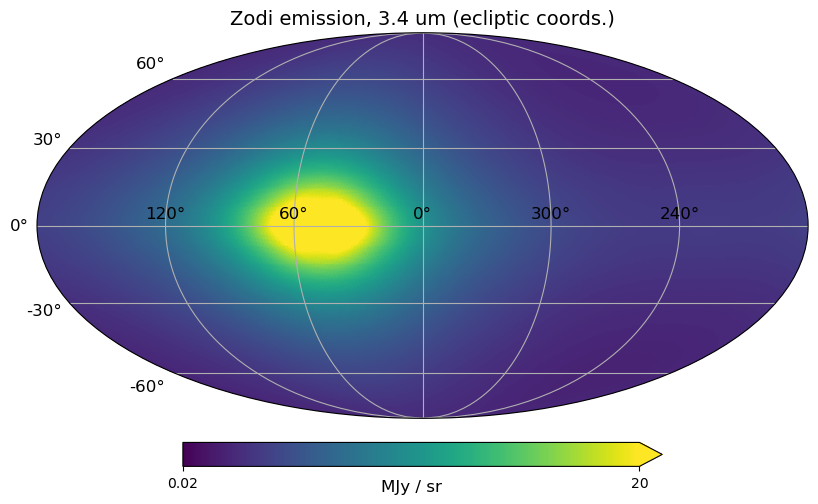

In [4]:
# plot
hp.projview(emission.value, unit=emission.unit, title=f'Zodi emission, {wl} (ecliptic coords.)', norm='log', min=.02, max=20,
            graticule=True, graticule_labels=True)

### full sky zodi map from $\varepsilon\sim90^\circ$

In [16]:
# load maps generated from zodimap.py
mapdir = '/scratch/aew492/quasars/catalogs/maps/zodi'
# wavelengths
wl_min = 1.25 << u.um
wl_w1 = 3.4 << u.um
wl_w2 = 4.6 << u.um
wls = [wl_min, wl_w1, wl_w2]
fns = [
    os.path.join('/scratch/aew492/quasars/maps/zodi', f'script_zodimap_90degfromSun_oneyear_{wl.value:.2f}{wl.unit}.fits') for wl in wls
]
zodimaps = [
    fitsio.read(fn) for fn in fns
]
zodimap_min, zodimap_w1, zodimap_w2 = zodimaps

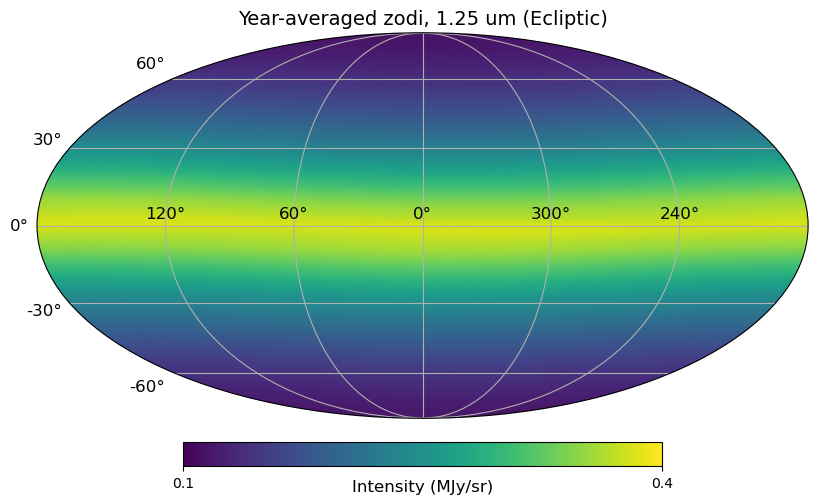

In [45]:
# plot
hp.projview(zodimap_min, min=1e-1, max=4e-1, norm='log', coord=['E'],
            unit=r'Intensity (MJy/sr)',
            title=f'Year-averaged zodi, {wl_min} (Ecliptic)',
            graticule=True, graticule_labels=True)

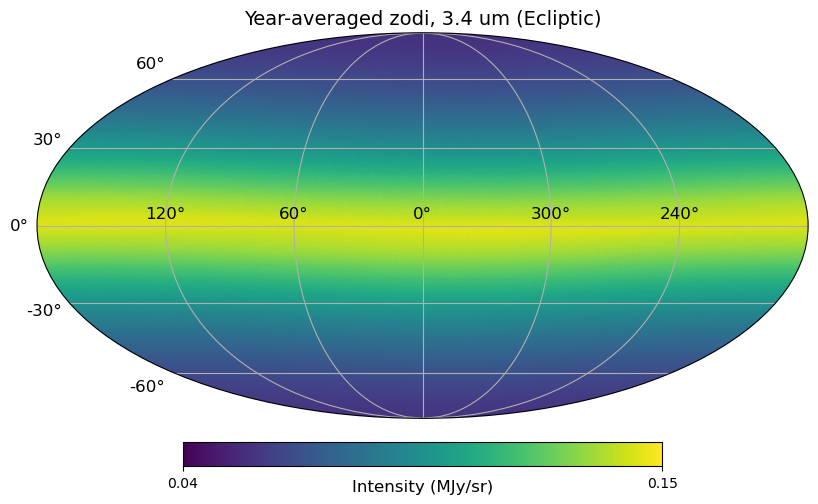

In [39]:
# plot
hp.projview(zodimap_w1, min=4e-2, max=1.5e-1, norm='log', coord=['E'],
            unit=r'Intensity (MJy/sr)',
            title=f'Year-averaged zodi, {wl_w1} (Ecliptic)',
            graticule=True, graticule_labels=True)

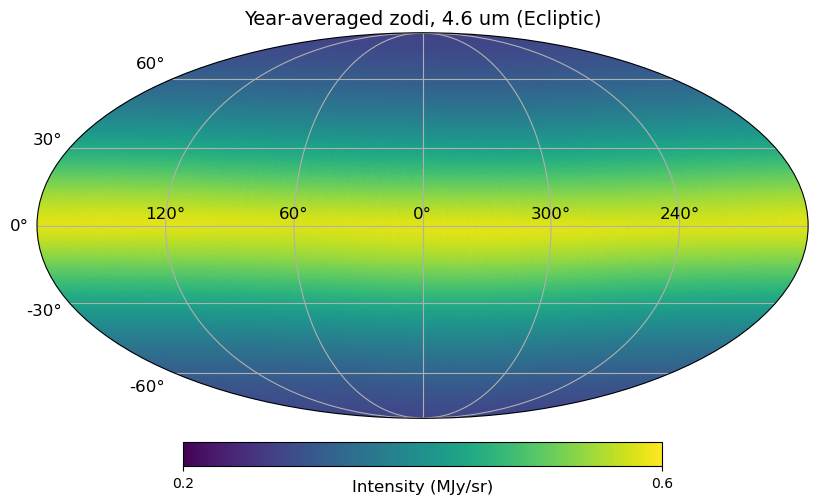

In [43]:
# plot
hp.projview(zodimap_w2, min=2e-1, max=6e-1, norm='log', coord=['E'],
            unit=r'Intensity (MJy/sr)',
            title=f'Year-averaged zodi, {wl_w2} (Ecliptic)',
            graticule=True, graticule_labels=True)

Text(0.5, 0.98, 'Year-averaged zodi (Ecliptic coords.)')

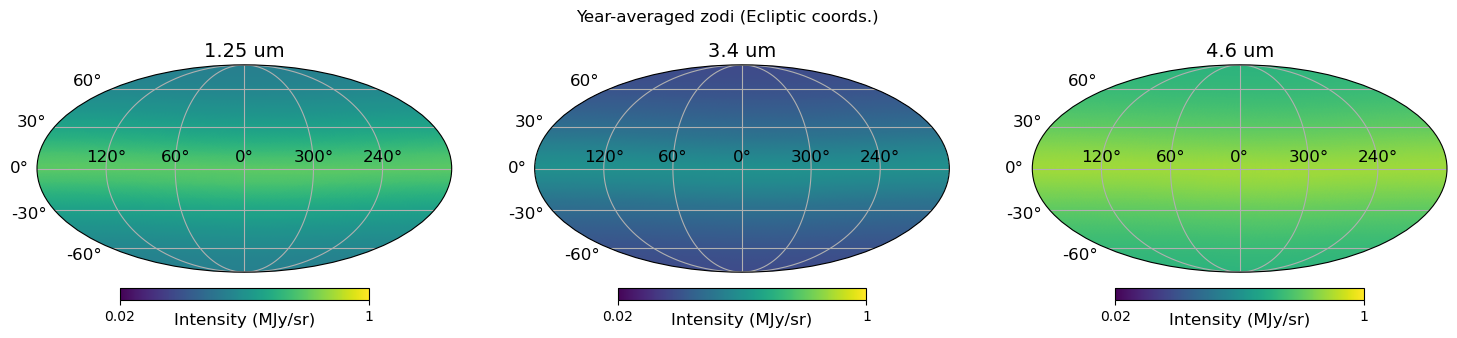

In [46]:
# plot all three with the same color scale
fig = plt.figure(figsize=(15,3.5))
kwargs = dict(min=2e-2, max=1e0, coord=['E'], norm='log', unit=r'Intensity (MJy/sr)',
              graticule=True, graticule_labels=True)
for i, zodimap in enumerate(zodimaps):
    hp.projview(zodimap, title=wls[i], sub=(1,3,i+1), **kwargs)
fig.suptitle(f'Year-averaged zodi (Ecliptic coords.)')

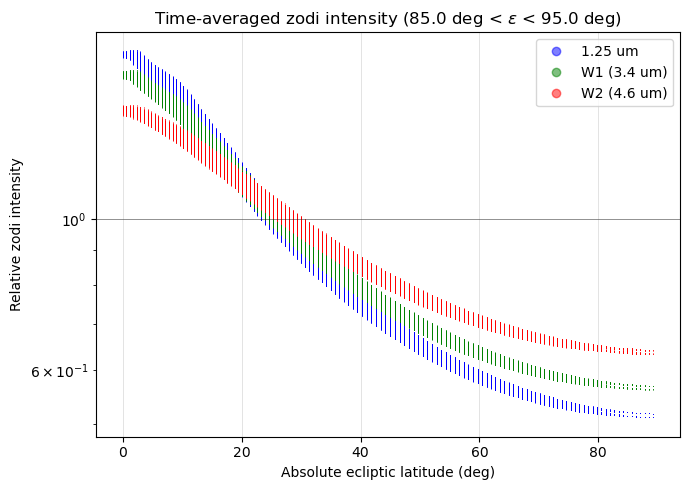

In [44]:
# BRIGHTNESS AS A FUNCTION OF ECLIPTIC LATITUDE
# mean-normalize
zodimap_min_ = zodimap_min / np.mean(zodimap_min)
zodimap_w1_ = zodimap_w1 / np.mean(zodimap_w1)
zodimap_w2_ = zodimap_w2 / np.mean(zodimap_w2)

zodimaps = [zodimap_min_, zodimap_w1_, zodimap_w2_]
colors = ['b', 'g', 'r']
labels = [wl_min, f'W1 ({wl_w1})', f'W2 ({wl_w2})' ]
legend_elements = []

# fit a slope to absolute latitude for each of these, and plot
elat = obscrd_hpx.geocentrictrueecliptic.lat.deg
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)

for i, zodimap in enumerate(zodimaps):

    p = np.polyfit(np.abs(elat), zodimap, deg=1)
    kwargs = dict(c=colors[i], alpha=0.5, ls='None')
    # ax.plot(np.abs(elat), np.abs(elat) * p[0] + p[1], c='b', label=f'{wl_bp}: y={p[0]:.3f}x+{p[1]:.1f}')
    ax.plot(np.abs(elat), zodimap, marker=',', **kwargs)
    legend_elements.append(mpl.lines.Line2D([0], [0], marker='o', label=labels[i], **kwargs))

ax.semilogy()
ax.axhline(1., c='k', alpha=0.5, lw=0.5)
ax.grid(alpha=0.5, lw=0.5)
ax.set_xlabel('Absolute ecliptic latitude (deg)')
ax.set_ylabel('Relative zodi intensity')
ax.set_title(f'Time-averaged zodi intensity ({min_epsilon} < 'r'$\epsilon$ < 'f'{max_epsilon})')
ax.legend(handles=legend_elements)

In [47]:
# write maps using healpy function
save_fns = [
    os.path.join('/scratch/aew492/quasars/maps/zodi', f'zodimap_90degfromSun_oneyear_{wl.value:.2f}{wl.unit}.fits') for wl in wls
]
for i, fn in enumerate(save_fns):
    hp.write_map(fn, zodimaps[i])

setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
